In [1]:
#Importing packages
#Model
from sklearn.ensemble import RandomForestClassifier
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [2]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib
import matplotlib.pyplot as plt

In [3]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("./")

In [4]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [5]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)


In [6]:
#Reading the data
ML_data= pd.read_csv("./Original data/ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./Original data/X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original data/raw_data.csv',index_col=0)
Raw_data['Hydrogel-forming ability']=np.where(Raw_data['Hydrogel-forming ability']=='Gelator', 1, 0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(71, 4175)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,267.28,8.352500,20.0734,33.3526,19.8921,36.9899,0.627294,1.042269,0.621628,1.155934,...,0.0,0.0,0.0,10.0,16.0,0.842105,7.75,0.407895,17.966397,8.618182
Ma_2019_U,244.23,8.421724,17.9656,30.5854,17.5454,33.3290,0.619503,1.054669,0.605014,1.149276,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_C,243.25,8.108333,18.2722,31.3599,18.0966,34.6179,0.609073,1.045330,0.603220,1.153930,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_G,283.28,8.584242,20.7882,34.6799,20.3466,38.1993,0.629945,1.050906,0.616564,1.157555,...,0.0,0.0,0.0,5.0,17.0,0.850000,8.75,0.437500,19.586399,10.257197
Ma_2019_dA,251.28,8.105806,19.3586,32.0253,19.4376,35.7805,0.624471,1.033074,0.627019,1.154210,...,0.0,0.0,0.0,10.0,15.0,0.833333,7.00,0.388889,17.259745,8.115820


In [8]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Hydrogel-forming ability'].values
clf=RandomForestClassifier(random_state=0)

In [9]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.625143,0.014336
Accuracy_train,0.978164,0.001539
F1 Score,0.653154,0.015627
Precision,0.652747,0.015257
Recall,0.684643,0.024731
Roc_auc,0.722691,0.017949


In [10]:
#Model2 （144 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.668667,0.013993
Accuracy_train,0.978164,0.001539
F1 Score,0.704167,0.012996
Precision,0.681876,0.014414
Recall,0.750357,0.021222
Roc_auc,0.751267,0.016059


In [13]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) 
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) 
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=1
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-04-22 23:50:26,227] A new study created in memory with name: no-name-bf62266f-b11c-495e-a9b0-ae0a17598eb0
[I 2023-04-22 23:50:29,142] Trial 0 finished with value: 0.5352380952380952 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.5352380952380952.
[I 2023-04-22 23:50:31,476] Trial 1 finished with value: 0.5352380952380952 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.5352380952380952.
[I 2023-04-22 23:50:36,296] Trial 2 finished with value: 0.5352380952380952 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.5352380952380952.
[I 2023-04-22 23:50:39,268] Trial 3 finished with value: 0.5352380952380952 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [14]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 913, 'max_depth': 8, 'max_features': 27, 'min_impurity_decrease': 0.004905793398417582}


In [12]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 942, 'max_depth': 5, 'max_features': 23, 'min_impurity_decrease': 0.003301072152590219}


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_rf=ML_data[columns]
data_rf.to_csv("./Results/data_rf.csv",sep=',')
X_RF=np.array(data_rf)

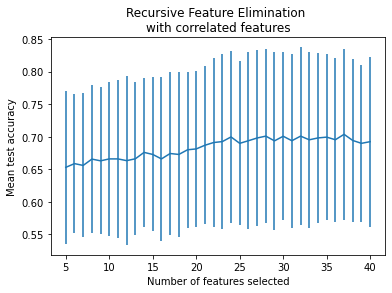

In [17]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [18]:
#Model3（len(columns) descriptors）
Model3_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model3_clf.fit(X_RF, y)
#Model3
Model3=Model_results(Model3_clf,X_RF,y,Cv_model)
Model3


,Mean,Se
Accuracy_test,0.666190,0.013751
Accuracy_train,0.978164,0.001539
F1 Score,0.702521,0.012612
Precision,0.683877,0.015152
Recall,0.749643,0.021431
Roc_auc,0.742355,0.015691


In [19]:
Model3_clf=Model3_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model3_clf, './Models/RF.pkl')
RF= joblib.load(filename='./Models/RF.pkl')

In [20]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_rf.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,MATS3p,SM10_AEA(dm),GATS7s,F07[N-O],VE1sign_Dz(v),VE3sign_D/Dt,P_VSA_charge_4,CATS2D_09_DA,B09[O-O],CATS2D_06_DL,...,IC1,MATS2m,MATS2p,GATS6i,P_VSA_charge_2,Eig03_AEA(ed),CATS2D_05_DA,GATS2p,s2_pathLength,GATS8i
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.148099,0.279629,0.937287,-0.166667,0.401550,0.672502,0.359389,0.0,0.0,0.25,...,0.543397,0.369317,0.839555,-0.520914,0.139311,0.002663,-0.166667,0.120946,0.272727,-0.234805
13463,0.167609,0.382490,0.371194,0.166667,0.297744,0.433674,0.000000,0.0,0.0,0.00,...,0.720324,-0.145355,0.534014,0.173585,0.015761,0.580423,0.166667,0.224814,0.090909,0.557069
39148,0.082452,0.442684,0.247689,0.500000,0.278206,0.618221,0.000000,0.4,0.0,0.00,...,0.627672,0.490001,1.437855,-0.901637,0.015761,0.676324,0.500000,-0.226505,0.272727,0.231925
56328,0.345941,0.338437,0.498540,0.166667,0.422186,0.448300,0.000000,0.4,0.0,0.00,...,0.768553,0.185979,0.786846,0.422220,0.015761,0.316590,0.000000,0.189035,0.030303,0.464901
67358,0.202511,0.471826,0.577994,0.500000,0.354301,0.414307,0.000000,0.4,0.0,0.00,...,0.768763,0.151812,0.729538,0.090504,0.000000,0.632697,0.500000,0.423568,0.090909,0.469174


In [25]:
#Predicted results
Predicted_data=pd.DataFrame(RF.predict_proba(X_test),columns=['Probability of nongelator','Probability of gelator'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of gelator" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/RF_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of nongelator,Probability of gelator
cid,,
136623055,0.052128,0.947872
135508725,0.052756,0.947244
135402034,0.052756,0.947244
135768162,0.052756,0.947244
135514572,0.052756,0.947244


In [23]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3],axis=1)
Model_data.to_csv("./Results/RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*6,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                  
Model               Model 1             Model 2             Model 3          
Values                 Mean        Se      Mean        Se      Mean        Se
Accuracy_test      0.625143  0.014336  0.668667  0.013993  0.666190  0.013751
Accuracy_train     0.978164  0.001539  0.978164  0.001539  0.978164  0.001539
F1 Score           0.653154  0.015627  0.704167  0.012996  0.702521  0.012612
Precision          0.652747  0.015257  0.681876  0.014414  0.683877  0.015152
Recall             0.684643  0.024731  0.750357  0.021222  0.749643  0.021431
Roc_auc            0.722691  0.017949  0.751267  0.016059  0.742355  0.015691

In [24]:
#Feature Importance
RF= joblib.load(filename='./Models/RF.pkl')
result = permutation_importance(
    RF, X_RF, y, n_repeats=1000, random_state=0, n_jobs=2)
clf2_importances = pd.Series(result.importances_mean, index= columns)
importances_mean=pd.DataFrame(clf2_importances, index=columns)
importances_std=pd.DataFrame(result.importances_std, index=columns)
importances_se=pd.DataFrame(result.importances_std/math.sqrt(10), index=columns)
importances_=pd.concat([importances_mean,importances_std,importances_se],axis=1)
importances_.columns=["mean","std","se"]
Feature_importance=importances_.sort_values(by="mean",ascending=True)
Feature_importance.columns=[['RandomForest']*3,["mean","std","se"]]
Feature_importance.columns.names=['Method','Values']
Feature_importance.to_csv('./Results/RF_feature_importance.csv',encoding='utf-8')
Feature_importance

Method         RandomForest                    
Values                 mean       std        se
P_VSA_charge_7    -0.000620  0.008774  0.002775
H-052             -0.000394  0.007756  0.002453
GATS6i            -0.000394  0.008650  0.002735
F07[N-O]          -0.000254  0.008656  0.002737
F10[O-O]          -0.000211  0.007877  0.002491
CATS2D_03_DL      -0.000141  0.008284  0.002619
s2_pathLength     -0.000127  0.007700  0.002435
P_VSA_LogP_5      -0.000099  0.010127  0.003202
SpDiam_AEA(ed)    -0.000056  0.009214  0.002914
P_VSA_charge_2     0.000000  0.000000  0.000000
Mv                 0.000000  0.000000  0.000000
P_VSA_LogP_4       0.000000  0.000000  0.000000
nN(CO)2            0.000000  0.000000  0.000000
Eig04_AEA(bo)      0.000000  0.000000  0.000000
F05[N-N]           0.000000  0.000000  0.000000
GATS8i             0.000000  0.000000  0.000000
CATS2D_05_DL       0.000000  0.000000  0.000000
CATS2D_04_AA       0.000000  0.000000  0.000000
SpMAD_EA(ri)       0.000000  0.000000  0.000000
B09[O-O]           0.000000  0.000000  0.000000
CATS2D_09_DA       0.000000  0.000000  0.000000
P_VSA_charge_4     0.000000  0.000000  0.000000
MATS2p             0.000000  0.000000  0.000000
CATS2D_09_AA       0.000000  0.000000  0.000000
GATS7s             0.000028  0.012832  0.004058
IC1                0.000042  0.002041  0.000645
MATS3m             0.000056  0.008952  0.002831
CATS2D_06_DL       0.000070  0.009583  0.003031
Eig03_AEA(ed)      0.000169  0.003446  0.001090
SM10_AEA(dm)       0.000197  0.009488  0.003000
CATS2D_05_DA       0.000211  0.009664  0.003056
VE1sign_B(p)       0.000254  0.013359  0.004225
GATS2p             0.000282  0.006165  0.001950
MATS2m             0.000366  0.009872  0.003122
VE1sign_Dz(v)      0.000592  0.008069  0.002552
VE3sign_D/Dt       0.003521  0.008279  0.002618
MATS3p             0.008507  0.015046  0.004758